# Importation des données

In [1]:
import os
import string
import re
import pandas as pd
import pickle

os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [2]:
df_test = pd.read_csv("data/sentimental_analysis/bdd-test.csv",sep=';/;',header=0,engine='python',encoding='UTF-8')
df_train = pd.read_csv("data/sentimental_analysis/bdd-train.csv",sep=';/;',header=0,engine='python',encoding='UTF-8')

In [167]:
print(df_train[0:1])
print(df_test[0:1])

                                              tweets polarity
0  Et finito! Tous les entrepreneurs de salles de...        0
                                              tweets  polarity
0  Etc. J'étais en fait celui qui lui enseignait ...         4


In [168]:
# On traite la mise en forme comme dans notre corpus
def mise_en_forme_phrase (phrase):
    phrase = phrase.lower()
    # On enlève la ponctuation + certaines apostrophes
    phrase = phrase.translate(str.maketrans('', '', string.punctuation + "'’«»—"))
    # On enlève les passages à la ligne
    phrase = re.sub('\\n', ' ', phrase)
    # On enlève les tabulations
    phrase = re.sub('\\t', ' ', phrase)
    # On enlève les espaces multiples et les espaces à la fin des phrases
    phrase = re.sub(' +', ' ', phrase)
    phrase = re.sub(' +$', '', phrase)
    phrase = re.sub('^ +', '', phrase)
    # phrase.isalpha() # inutile
    return(phrase)

In [169]:
corpus_test = []
for ligne in df_test.itertuples():
    corpus_test.append([ligne.polarity,mise_en_forme_phrase(ligne.tweets)])
corpus_test[0:2]

[[4, 'etc jétais en fait celui qui lui enseignait le texte'],
 [4, 'yay un autre jour et la discothèque demain']]

In [170]:
corpus_train = []
for ligne in df_train.itertuples():
    corpus_train.append([ligne.polarity,mise_en_forme_phrase(ligne.tweets)])
corpus_train[0:2]

[['0',
  'et finito tous les entrepreneurs de salles de bains étaient dans la maison citations entrantes alors jai besoin de mordre la balle'],
 ['0', 'awww ça suce allezvous à sydney']]

In [171]:
corpus_test_modif = [[-1 if score == 0 else 1,tweet] for score, tweet in corpus_test]

In [172]:
corpus_train_modif = [[-1 if score == '0' else 1,tweet] for score, tweet in corpus_train]

In [174]:
val_pos = [[score,tweet] for score,tweet in corpus_train_modif if score == 1]
val_neg = [[score,tweet] for score,tweet in corpus_train_modif if score == -1]

In [176]:
import random
from random import sample
random.seed(1)
val_pos_choix = sample(val_pos,25000)
val_neg_choix = sample(val_neg,25000)

In [177]:
corpus_train_total = val_pos_choix + val_neg_choix

In [178]:
with open("data/sentimental_analysis/corpus_train.file", "wb") as f:
    pickle.dump(corpus_train_total, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/corpus_test.file", "wb") as f:
    pickle.dump(corpus_test_modif, f, pickle.HIGHEST_PROTOCOL)

# Modèle : prédiction sentiment de la phrase en fonction du sentiment moyen des mots

In [3]:
# Si on veut récup les fichiers
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [11]:
phrases = [tweet.split() for (score, tweet) in corpus_train]

In [12]:
mots = [item for sublist in phrases for item in sublist]

In [13]:
vocabulaire = list(dict.fromkeys(mots))
print("Nombre de mots :", len(mots))
print("Taille du vocabulaire :", len(vocabulaire))

Nombre de mots : 674732
Taille du vocabulaire : 39650


In [14]:
matrice_sentiments = {mot:(0,0) for mot in vocabulaire}

In [15]:
def sentiment_plus(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)
    
for (score, tweet) in corpus_train:
    for mot in tweet.split():
        if score == 1:
            sentiment_plus(mot)
        else:
            sentiment_moins(mot)

In [16]:
matrice_sentiments["la"]

(5999, 6471)

In [17]:
matrice_sentiments_val = {mot:(matrice_sentiments[mot][0]-matrice_sentiments[mot][1])/((matrice_sentiments[mot][0]+matrice_sentiments[mot][1]))
                          for mot in vocabulaire}

In [18]:
print(matrice_sentiments_val["le"])
print(matrice_sentiments_val["gentil"])
print(matrice_sentiments_val["méchant"])

-0.0031257147213539682
0.3333333333333333
-0.3448275862068966


In [19]:
def sentiments_phrase(phrase):
    somme = 0
    n = 0
    for mot in phrase.split():
        somme += matrice_sentiments_val[mot]
        n += 1
    if(n!=0):
        return(somme/n)
    else:
        return 0
sentiments_phrase("le gentil méchant")

-0.004873322531639079

In [20]:
# Eval sur train
sentiments_tweets = [[tweet, score, sentiments_phrase(tweet)] for (score, tweet) in corpus_train]

In [21]:
resultat = [[tweet, 1 if ((val > 0 and score == 1) or (val < 0 and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]

In [22]:
compteur = 0
n = 0
for (tweet, res) in resultat:
    n += 1
    if res == 1:
        compteur+=1
print(compteur/n)

0.8441


In [23]:
def eval(a):
    resultat = [[tweet, 1 if ((val > a and score == 1) or (val < a and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]
    return sum(res for (tweet,res) in resultat)/len(resultat)

res_final = {a/100:eval(a/100) for a in range(-100,100)}

In [24]:
res_final

{-1.0: 0.5,
 -0.99: 0.50222,
 -0.98: 0.50222,
 -0.97: 0.50222,
 -0.96: 0.50222,
 -0.95: 0.50224,
 -0.94: 0.50226,
 -0.93: 0.50228,
 -0.92: 0.5023,
 -0.91: 0.50234,
 -0.9: 0.50244,
 -0.89: 0.50244,
 -0.88: 0.50252,
 -0.87: 0.50254,
 -0.86: 0.50256,
 -0.85: 0.50256,
 -0.84: 0.50258,
 -0.83: 0.50258,
 -0.82: 0.50258,
 -0.81: 0.5026,
 -0.8: 0.50266,
 -0.79: 0.50274,
 -0.78: 0.50278,
 -0.77: 0.5028,
 -0.76: 0.50284,
 -0.75: 0.5029,
 -0.74: 0.50308,
 -0.73: 0.50312,
 -0.72: 0.50318,
 -0.71: 0.50334,
 -0.7: 0.5034,
 -0.69: 0.5035,
 -0.68: 0.50356,
 -0.67: 0.50362,
 -0.66: 0.50382,
 -0.65: 0.50402,
 -0.64: 0.50416,
 -0.63: 0.50432,
 -0.62: 0.5046,
 -0.61: 0.50484,
 -0.6: 0.505,
 -0.59: 0.50534,
 -0.58: 0.5057,
 -0.57: 0.50594,
 -0.56: 0.5062,
 -0.55: 0.50644,
 -0.54: 0.5069,
 -0.53: 0.50726,
 -0.52: 0.50776,
 -0.51: 0.50836,
 -0.5: 0.50898,
 -0.49: 0.50998,
 -0.48: 0.51078,
 -0.47: 0.5116,
 -0.46: 0.51254,
 -0.45: 0.51342,
 -0.44: 0.51462,
 -0.43: 0.51604,
 -0.42: 0.51764,
 -0.41: 0.51956,
 -0

In [25]:
# Sur test
def sentiments_phrase(phrase):
    somme = 0
    n = 0
    for mot in phrase.split():
        if mot in matrice_sentiments_val.keys():
            somme += matrice_sentiments_val[mot]
        n += 1
    if(n!=0):
        return(somme/n)
    else:
        return 0

sentiments_tweets = [[tweet, score, sentiments_phrase(tweet)] for (score, tweet) in corpus_test]

In [26]:
resultat = [[tweet, 1 if ((val > 0 and score == 1) or (val < 0 and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]

def eval(a):
    resultat = [[tweet, 1 if ((val > a and score == 1) or (val < a and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]
    return sum(res for (tweet,res) in resultat)/len(resultat)

res_final_test = {a/100:eval(a/100) for a in range(-100,100)}

In [27]:
res_final_test

{-1.0: 0.5017579105976896,
 -0.99: 0.5025113008538423,
 -0.98: 0.5025113008538423,
 -0.97: 0.5025113008538423,
 -0.96: 0.5025113008538423,
 -0.95: 0.5025113008538423,
 -0.94: 0.5025113008538423,
 -0.93: 0.5025113008538423,
 -0.92: 0.5025113008538423,
 -0.91: 0.5025113008538423,
 -0.9: 0.5025113008538423,
 -0.89: 0.5025113008538423,
 -0.88: 0.5025113008538423,
 -0.87: 0.5025113008538423,
 -0.86: 0.5025113008538423,
 -0.85: 0.5025113008538423,
 -0.84: 0.5025113008538423,
 -0.83: 0.5025113008538423,
 -0.82: 0.5025113008538423,
 -0.81: 0.5025113008538423,
 -0.8: 0.5025113008538423,
 -0.79: 0.5025113008538423,
 -0.78: 0.5025113008538423,
 -0.77: 0.5025113008538423,
 -0.76: 0.5025113008538423,
 -0.75: 0.5025113008538423,
 -0.74: 0.5025113008538423,
 -0.73: 0.5027624309392266,
 -0.72: 0.5027624309392266,
 -0.71: 0.5030135610246107,
 -0.7: 0.5030135610246107,
 -0.69: 0.5030135610246107,
 -0.68: 0.5030135610246107,
 -0.67: 0.5030135610246107,
 -0.66: 0.5030135610246107,
 -0.65: 0.50301356102461

In [28]:
import matplotlib.pyplot as plt
import numpy as np

keys_train = np.fromiter(res_final.keys(), dtype=float)
vals_train = np.fromiter(res_final.values(), dtype=float)

keys_test = np.fromiter(res_final_test.keys(), dtype=float)
vals_test = np.fromiter(res_final_test.values(), dtype=float)

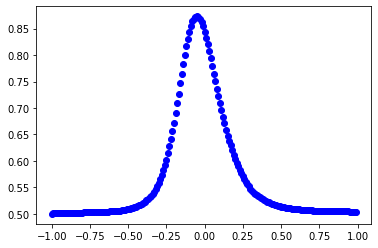

In [29]:
plt.plot(keys_train,vals_train,"bo")

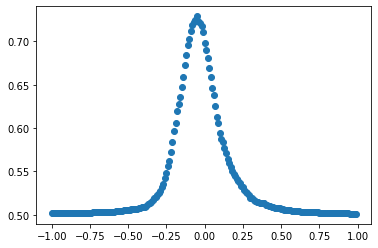

In [30]:
plt.plot(keys_test,vals_test,'o')

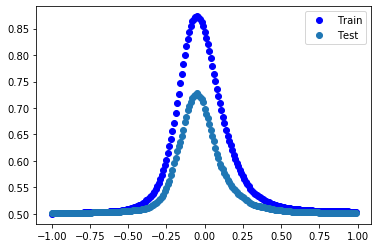

In [32]:
plt.plot(keys_train,vals_train,"bo")
plt.plot(keys_test,vals_test,'o')
plt.legend(["Train","Test"])

In [33]:
[(key) for key in res_final_test.keys() if res_final_test[key] == max(vals_test)]

[-0.05]

In [34]:
[(key) for key in res_final.keys() if res_final[key] == max(vals_train)]

[-0.05]

In [35]:
print(res_final[-0.05])
print(res_final_test[-0.05])

0.87328
0.7290306378704169


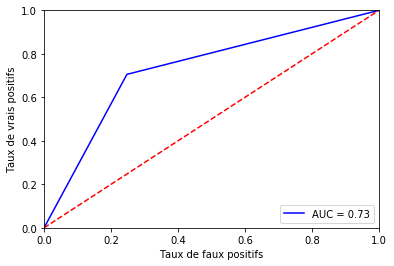

In [37]:
resultat_final = [[tweet, score, 1 if (val > -0.05) else -1]
            for (tweet, score, val) in sentiments_tweets]

# Essai courbe ROC
import sklearn.metrics as metrics
preds = [res for (tweet, score, res) in resultat_final]
Y_test = [score for (tweet, score, res) in resultat_final] 
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
#plt.title('Courbe ROC - Régression logistique - Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

# Modèle aléatoire : on prédit 1 ou -1 de manière random

In [38]:
import random
from random import sample
random.seed(1)
def choix():
    return sample((1,-1),1)

sentiments_tweets = [[tweet, score, choix()[0]] for (score, tweet) in corpus_train]

In [39]:
resultat = [[tweet, 1 if val == score else 0] for (tweet, score, val) in sentiments_tweets]

In [40]:
sum(res for (tweet,res) in resultat)/len(resultat)

0.50154

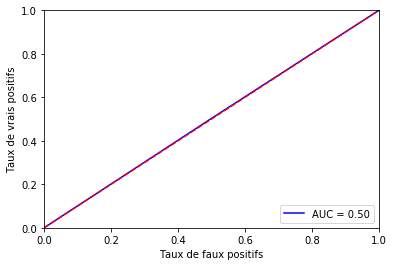

In [41]:
# Essai courbe ROC
import sklearn.metrics as metrics
preds = [res for (tweet, score, res) in sentiments_tweets]
Y_test = [score for (tweet, score, res) in sentiments_tweets] 
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
#plt.title('Courbe ROC - Régression logistique - Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()